# FCS Tutoring Session 9

Welcome to our ninth exercise session. Today, we will implement a supervised machine-learning classifier from scratch and thus strip away all the magic.

Using the Naive Bayes classifier we want to predict for a given movie review whether the review is positive or negative. Naive Bayes is a way of supervised machine learning as the class labels are known.

Keep in mind the trade-off that we always have in machine learning:
With supervised methods like k-Nearest-Neigbor or Naive Bayes wit relatively few data we can implement a classifier. However, wen processing an unknown observation we need to compare tis observation every time against all the data, so our model as to 'remember' the training data. Thus, the training process is very cheap the prediction very costly in terms of computational power and time wise.
On the other hand with unsupervised methods like CNN for image classification, the model needs a lot of training data to calculate the ideal weights trough backward-propagation. However, when we want to label a new image in evaluation (a new observation) the model can do this relatively fast.

This is a very important concept to keep in mind and it puts you in a great position in a ML job interview if you understand this by heart.

For any questions, please contact me on Slack.

Janick Spirig, 14.05.2021


## Our Classifier

Our classifier sould take a movie review as input and decide whether it is a positive or negative review.

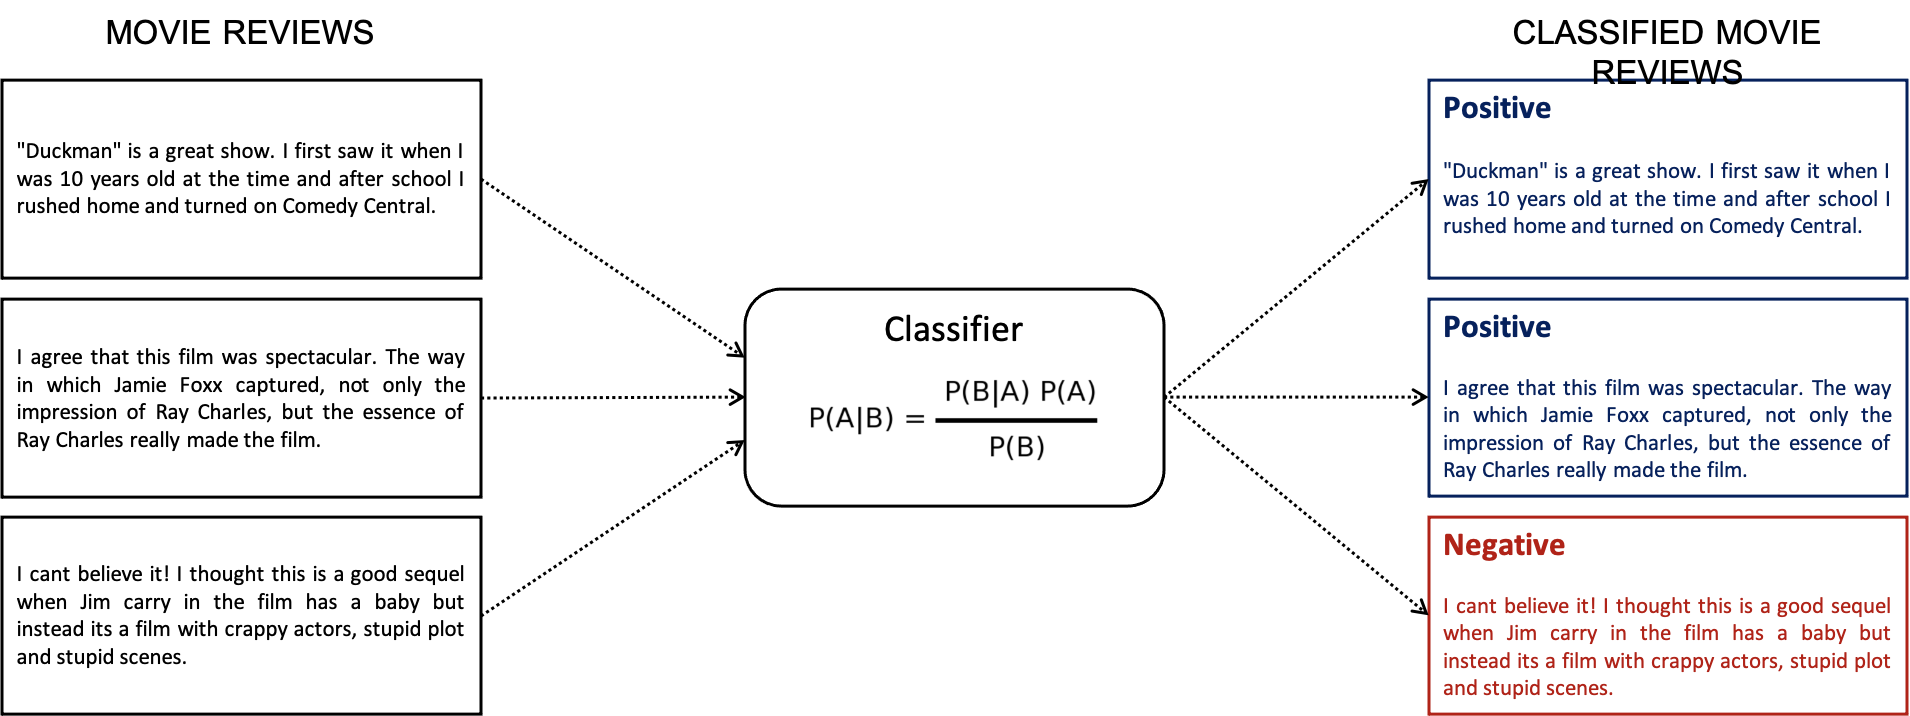



In [2]:
from collections import defaultdict
import math
import pandas as pd

In [3]:
# Let's load the data and extract rows for training
train_df = pd.read_csv("movie_train.csv")
train_df = train_df.iloc[7500:-7500, :]

In [4]:
# Let's load the data and extract rows for testing
test_df = pd.read_csv("movie_test.csv")
test_df = test_df.iloc[7500:-7500, :]

In [5]:
# function to caluclate the priors P(A)
def calculate_priors(df):
  '''
  Calculates the probability of given classes, based on how often they appear in a DataFrame.
  
  Return a dictionary mapping the class to its probability.

  Example: The class "apple" appears in two rows, the class "banana" in three.
  The probability for the "apple" class is 2/5, the probability for banana is 
  3/5.
  You have to return a dictionary:
    {"apple": 0.4, "banana": 0.6}

  :param df: A pandas.DataFrame containing a column "class" and a column "text". 
  :return: A dictionary mapping the class to its probability.
  '''
  # caluclate relative frequencies of the unique values in the class column and return the result as a dict
  return df['class'].value_counts(normalize=True).to_dict()

In [6]:
priors = calculate_priors(train_df)
print(priors)

{'neg': 0.5, 'pos': 0.5}


**Conditional Probabilities (with add-1 smoothing)**: $P(w|c) = \frac{count(w, c) + 1}{count(c) + |V|}$

Example: $P(fruit|apple) = 0.3$

$count(w, c)$ = How often word $w$ appears in documents of class $c$.

$count(c)$ = How many words appear in documents of class $c$.

$|V|$ = How many different words exist in the dataset.

**Prior**: $P_{prior}(c) = \frac{N_c}{N}$, where $N$ is the total number of documents and $N_c$ is the number of documents with class $c$

**Choosing a class for document $d$**: $argmax_{c \in C} P(c|d)$ with $P(c|d) = P_{prior}(c) * \prod_{w \in d} P(w|c)$

You can also refer to the lecture slides where you can find an example calculation.


In [7]:
# function to calculate count(w, c)
def calculate_class_term_frequency(df, classes):
  """
  For each class, calculates the frequency of terms appearing in texts of this class.

  In the DataFrame, each row has an entry for "text" and one for "class".
  The values in the "text" column are strings (= actual texts).
  Your task is to calculate the frequency (= how often a word appears) for each of the classes.

  Convert the terms to lowercase.

  Example: 
    There are two texts with the "apple" class. 
    There are three texts with the "banana" class.
    The word "fruit" appears five times in the texts of the "apple" class, and 
    two times for texts of the "banana" class.
    The total frequency of the word "fruit" is 7. The frequency for the "apple"
    class is 5. The frequency for the "banana" class is 2.

  :param df: A pandas.DataFrame containing a column "class" and a column "text".
  :param classes: A list of strings containing the possible values for the "class" column.

  :return:
    - A set containing all the terms (list of string)
    - a dictionary containing the frequency of terms appearing in texts of each class in the following format:
      {class(string): 
        {term(string): frequency(int), 
        ...}, 
      ...}

  """
  # create empty result variables
  result_set = set()
  result_dict = dict()

  # add for each class a sub-dictionary to the parent-dictionary
  for c in classes:
    result_dict[c] = dict()
  
  # iterate over all movie reviews
  for index, row in df.iterrows():

    # convert the review to lower-case and split the review into single words
    words = row['text'].lower().split(" ")

    # add all the words to the set which holds all unique words, dupliactes are eliminated automatically
    [result_set.add(x) for x in words]

    # iterate over all words of the review
    for word in words: 

      # check if word already occurred before
      if not word in result_dict[row['class']]:

        # word appears for the first time
        # create new entry in dict and set counter to one
        result_dict[row['class']][word] = 1
        
      else:
        # increase the counter by one
        result_dict[row['class']][word] += 1
  
  # return the set with all unique words and the dict with all words and their frequencies per class
  return result_set, result_dict

In [8]:
terms, freqs_per_class = calculate_class_term_frequency(train_df, ["pos", "neg"])

print("The data containts {} different words".format(len(terms)))
print("The word 'bad' appears {} times in {} reviews.".format(freqs_per_class["neg"]["bad"], 'negative'))

The data containts 143944 differen tword
The word 'bad' appears 2160 times in negative reviews.


In [9]:
# function to calculate P(w|c)
def calculate_class_term_probs(terms, freqs_per_class):
  """

  Calculates the probability that a term appears in documents of a given class 
  and returns a nested dictionary containing the probabilities.

  Use Laplace (add-1) smoothing.
  Return a nested dictionary. The outer dictionary needs map terms to the 
  inner dictionaries. The inner dictionary maps class labels to probabilities.

  -> If the dictionary is accessed with a non-existing key but an existing class
  it should return the value 1/|V| ! <--

  Example:
    dct = {"fruit": {"apple": 0.3, "banana": 0.4}, "tree": {"apple": 0.5, "banana": 0.1}}
    foo = dct["rock"]["apple"]
    foo == 1/2
    Two terms exist in total (fruit and tree) so the total vocabulary size is 2.

  :param terms: A list of strings with all unique words that appear in the dataset.
  :param freqs_per_class: A dictionary containing the frequency of terms appearing in texts of each class.
  :return: A nested dictionary contains the terms and classes with the term's appearance probability.
  
  """
  # get list of all classes
  classes = freqs_per_class.keys()

  # create a default dict so that a new entry is created with the missing key as key and 1/V as value
  result_dict = defaultdict(lambda : {c:(1/len(terms)) for c in classes})
  
  # calculate the probabilities for each class
  for c, words in freqs_per_class.items():
    
    # calculate the probability for a single word
    for word in words:
      
      # apply formula count(w,c) + 1 / count(c) + V
      probability = (freqs_per_class[c][word] + 1) / (sum(words.values()) + len(terms))
      
      # store probability in result dict
      result_dict[word][c] = probability
  
  return result_dict 

In [10]:
cond_probs = calculate_class_term_probs(terms, freqs_per_class)

In [11]:
print(cond_probs["wow"]["pos"])
print(cond_probs["sad"]["neg"])

# NOTE: this is a word that does not exist in the data. therefore the value
# becomes 1/len(terms) - this is what the formula above for laplace smoothing tells us 
print(cond_probs["pneumonoultramicroscopicsilicovolcanoconiosis"]["pos"])

8.973062865278435e-06
0.000111077695447628
6.947146112377036e-06


In [12]:
# function that puts the wole formula together
def classify(text, priors, probs):
  """

  This function should predict a class for a given text.
  Use the priors you calculated in 1a).
  Use the probabilities you calculated in 1c).

  !!!!!!!
  Instead of multiplying the probabilites together you can take the logarithm
  of the probabilities and multiply them together. 
  !!!!!!!

  Use the Naive Bayes classification to assign the class.
  
  :param text: A string contains the text to clasiffy.
  :param priors: A dictionary mapping the class to its probability (From TASK 1a).
  :param probs: A nested dictionary contains the terms and classes with
  the term's appearance probability (From TASK 1c).
  :return: A string for the class label predicted.

  """
  # get list of all classes
  classes = priors.keys()

  # split the text provided to single words
  words = text.split(' ')

  # create empty dict to store the probabiliy for each class
  probabilities = dict()

  # calculate for each class the probability
  for c in classes:

    # empty list to store all single word probabilities
    single_probs = list()

    # calculate the probability for all single words
    for word in words:

      # convert the word to lower-case as it is stored like this in the probs dict
      word = word.lower()

      # apply Naive Bayes calculation, Px can be ignored
      Py = priors[c]
      Pxy = probs[word][c]
      single_probs.append(math.log(Pxy) * Py)
    
    # sum the single probabilities to receive the total probability for the whole text for the specific class
    probabilities[c] = sum(single_probs)

  # return the class with the highest cummulative probability
  return max(probabilities, key=probabilities.get)

In [13]:
t1 = "Today is an awful day."
pred = classify(t1, priors, cond_probs)
print(f"'{t1}' is {pred}")
t2 = "Today is a nice day."
pred = classify(t2, priors, cond_probs)
print(f"'{t2}' is {pred}")
t3 = "pneumonoultramicroscopicsilicovolcanoconiosis"
pred = classify(t3, priors, cond_probs)
print(f"'{t3}' is {pred}")
t4 = "This movie was very good and I liked it a lot."
pred = classify(t4, priors, cond_probs)
print(f"'{t4}' is {pred}")

'Today is an awful day.' is neg
'Today is a nice day.' is pos
'pneumonoultramicroscopicsilicovolcanoconiosis' is neg
'This movie was very good and I liked it a lot.' is pos


In [14]:
# fucntion that evaluates our classifier using te testing data
def evaluate(test, priors, probs):
  """
  Evaluate your classification.

  -> You may assume that the only classes are "pos" and "neg" ! <--

  The function takes a DataFrame to evaluate the classifier from TASK 1d.
  For each row in the test dataset, get the actual class from the "class" column
  and the text from the "text" column.
  Use your "classify(text, priors, probs)" function to get the predicted
  class label for each text.

  HINT: Count the TP, FP, FN, TN for each of the two classes, for each prediction. 

  Calculate the following metrics PER CLASS:
    - precision
    - recall
    - f1-measure

  :param test: A pandas.DataFrame containing a column "class" and a column "text".
  :param priors: A dictionary mapping the class to its probability (From TASK 1a).
  :param probs: A nested dictionary contains the terms and classes with
  the term's appearance probability (From TASK 1c).
  :return: two data frames
    - metrics, which should represent all the key figures for both classes
    - df_stat, shich should represent the confusion matrix

  """

  tp = 0
  fp = 0
  tn = 0
  fn = 0

  # run the classifier for each review in the test data-set
  for index, row in test.iterrows():
    # actual class of review -> ground-truth y
    c = row['class']
    # predicted class y^
    pred_c = classify(row['text'], priors, probs)

    # compare predicted class y^ with ground-truth y and track result
    if c == 'pos' and pred_c == 'pos':
      tp += 1
    elif c == 'neg' and pred_c == 'neg':
      tn += 1
    elif c == 'pos' and pred_c != c:
      fn += 1
    elif c == 'neg' and pred_c != c:
      fp += 1

  # calculate metrics for positive class
  pos_precision = tp / (tp + fp)
  pos_recall = tp / (tp + fn)
  pos_f1 = (2 * pos_precision * pos_recall) / (pos_precision + pos_recall)

  # calucalte metrics for negative class
  neg_precision = tn / (tn + fn)
  neg_recall = tn / (tn + fp)
  neg_f1 = (2 * neg_precision * neg_recall) / (neg_precision + neg_recall)

  # create confusion matrix as DataFrame
  df_stat = pd.DataFrame([[tp, fp], [fn, tn]], columns=[['Actual', 'Actual'],['Positive', 'Negative']], index=[['Predicted', 'Predicted'], ['Positive', 'Negative']])

  # create DataFrame to visualize the metrics
  # bring the data in a order so that it can be included in a DataFrame -> List of Tuples for example
  result_list = list()
  result_list.append(('pos', pos_precision, pos_recall, pos_f1))
  result_list.append(('neg', neg_precision, neg_recall, neg_f1))

  # create the DataFrame
  metrics = pd.DataFrame(result_list, columns=['Class', 'Precision', 'Recall','F1'])
  metrics.set_index('Class', inplace=True)
  metrics.index.name = None

  return metrics, df_stat

In [15]:
metrics, df_stat = evaluate(test_df, priors, cond_probs)

In [16]:
df_stat

Actual         
                   Positive Negative
Predicted Positive     3769      722
          Negative     1231     4278

In [17]:
metrics

,Precision,Recall,F1
pos,0.839234,0.7538,0.794226
neg,0.776547,0.8556,0.814159
